In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
stock_data = yf.download("AAPL", start="2021-01-01", end=None)

if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

# Reset index so Date becomes a column
stock_data = stock_data.reset_index()

stock_data.rename(columns={"Date": "date", "Close": "close"}, inplace=True)

print("Data shape:", stock_data.shape)

/tmp/ipython-input-387358800.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download("AAPL", start="2021-01-01", end=None)
[*********************100%***********************]  1 of 1 completed

Data shape: (1233, 6)


In [3]:
stock_data.head()

Price,date,close,High,Low,Open,Volume
0,2021-01-04,125.974464,130.062961,123.394814,129.975354,143301900
1,2021-01-05,127.531982,128.242613,125.020474,125.468268,97664900
2,2021-01-06,123.239067,127.570935,123.024906,124.329336,155088000
3,2021-01-07,127.444366,128.135524,124.465605,124.952331,109578200
4,2021-01-08,128.544373,129.108977,126.772682,128.914274,105158200


In [ ]:
# Closing price over time
plt.figure(figsize=(12, 5))
plt.plot(stock_data['date'], stock_data['close'])
plt.title("AAPL Closing Price - Last 5 Years")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

In [ ]:
# Volume over time
plt.figure(figsize=(12, 5))
plt.plot(stock_data['Date'], stock_data['Volume'])
plt.title("AAPL Trading Volume - Last 5 Years")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

In [4]:
close_prices = stock_data['close']
values = close_prices.values  # numpy array

# 80% training, 20% testing (time-based split)
training_data_len = math.ceil(len(values) * 0.8)

print("Total samples:", len(values))
print("Training samples (prices):", training_data_len)
print("Testing samples (prices):", len(values) - training_data_len)

# MinMax scaling (fit only on training data to avoid leakage)
scaler = MinMaxScaler(feature_range=(0, 1))

train_values = values[:training_data_len].reshape(-1, 1)
scaled_train = scaler.fit_transform(train_values)

# Transform the full series using the same scaler
scaled_full = scaler.transform(values.reshape(-1, 1))

print("First 5 scaled values:", scaled_full[:5].ravel())

Total samples: 1233
Training samples (prices): 987
Testing samples (prices): 246
First 5 scaled values: [0.09756155 0.1096846  0.07627038 0.10900264 0.11756462]


In [5]:
sequence_length = 60  # last 60 days

X_all = []
y_all = []

# We create samples for indices [sequence_length .. N-1]
for i in range(sequence_length, len(scaled_full)):
    # previous 60 days as features
    X_all.append(scaled_full[i - sequence_length:i, 0])  # shape: (60,)
    # day i as target (one step ahead)
    y_all.append(scaled_full[i, 0])

X_all = np.array(X_all)  # shape: (N - seq_len, 60)
y_all = np.array(y_all)  # shape: (N - seq_len,)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

X_all shape: (1173, 60)
y_all shape: (1173,)


In [6]:
# Split X_all, y_all into train and test (time-based)

train_size = training_data_len - sequence_length   # because first target index is sequence_length

X_train = X_all[:train_size]
y_train_scaled = y_all[:train_size]

X_test = X_all[train_size:]
y_test_scaled = y_all[train_size:]

print("Train window samples:", X_train.shape[0])
print("Test window samples:", X_test.shape[0])

# For metrics, we want y_test in ORIGINAL price scale:
# First test target index is 'training_data_len'
y_test = values[training_data_len:]
print("len(y_test original prices):", len(y_test))

Train window samples: 927
Test window samples: 246
len(y_test original prices): 246


In [7]:
# Train XGBoost regressor

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train_scaled)

print("Model trained.")

Model trained.


In [9]:
# Predict on test set and evaluate

# Predictions in SCALED space
y_pred_scaled = xgb_model.predict(X_test)  # shape: (num_test_samples,)

# Inverse transform to original price scale
y_pred_scaled_2d = y_pred_scaled.reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred_scaled_2d).ravel()

print("Predictions shape:", y_pred.shape)
print("First 5 predictions:", y_pred[:5])

print("len(y_test original):", len(y_test))

# Metrics in original price scale
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

Predictions shape: (246,)
First 5 predictions: [236.32967 235.56071 235.5817  235.57338 233.91972]
len(y_test original): 246


In [10]:
print("RMSE :", rmse)
print("MAE  :", mae)
print("R²   :", r2)

RMSE : 15.745549843058127
MAE  : 10.850935711124079
R²   : 0.5538992680258834


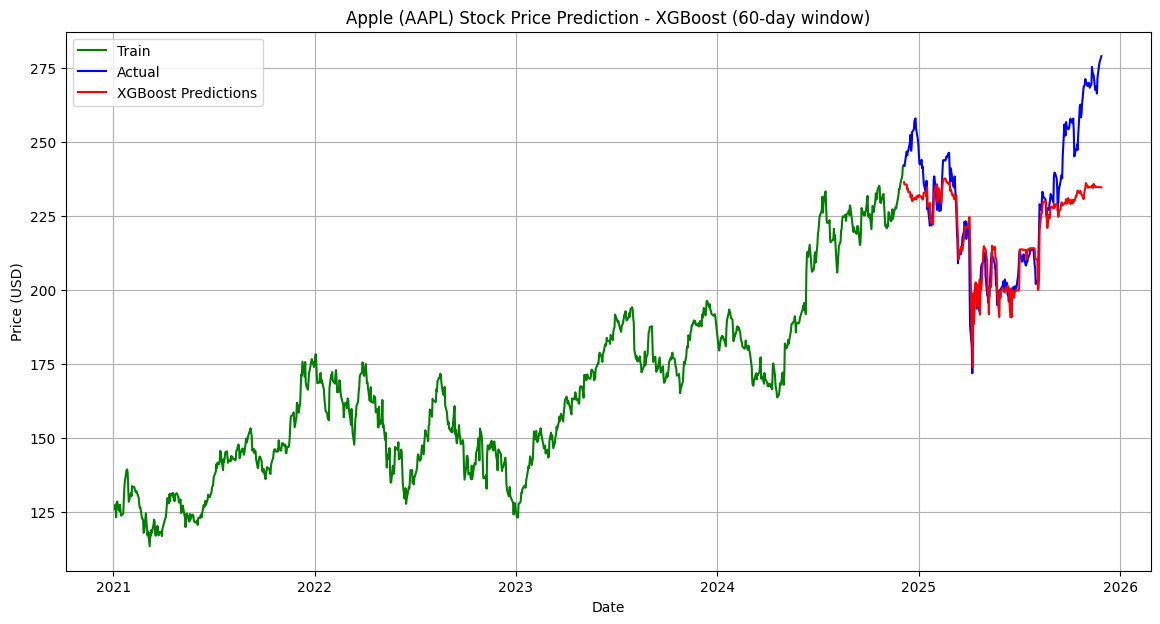

In [11]:
# Ensure date is datetime and set as index
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data.set_index('date', inplace=True)

data = stock_data[['close']]

train = data.iloc[:training_data_len]
validation = data.iloc[training_data_len:].copy()

# Add predictions to validation dataframe
validation['Predictions'] = y_pred

plt.figure(figsize=(14, 7))
plt.title('Apple (AAPL) Stock Price Prediction - XGBoost (60-day window)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

plt.plot(train['close'], label='Train', color='green')
plt.plot(validation['close'], label='Actual', color='blue')
plt.plot(validation['Predictions'], label='XGBoost Predictions', color='red')

plt.legend()
plt.grid(True)
plt.show()

In [12]:
#Hyperparameter tuning with GridSearchCV (on scaled labels)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

base_model = xgb.XGBRegressor(
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train_scaled)

print("Best params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_scaled_gs = best_model.predict(X_test)
y_pred_gs = scaler.inverse_transform(y_pred_scaled_gs.reshape(-1, 1)).ravel()

rmse_gs = np.sqrt(mean_squared_error(y_test, y_pred_gs))
mae_gs  = mean_absolute_error(y_test, y_pred_gs)
r2_gs   = r2_score(y_test, y_pred_gs)

print("===== XGBOOST + GRIDSEARCH PERFORMANCE =====")
print("RMSE :", rmse_gs)
print("MAE  :", mae_gs)
print("R²   :", r2_gs)

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
===== XGBOOST + GRIDSEARCH PERFORMANCE =====
RMSE : 15.165432240183248
MAE  : 10.301907361038332
R²   : 0.5861653416855981
